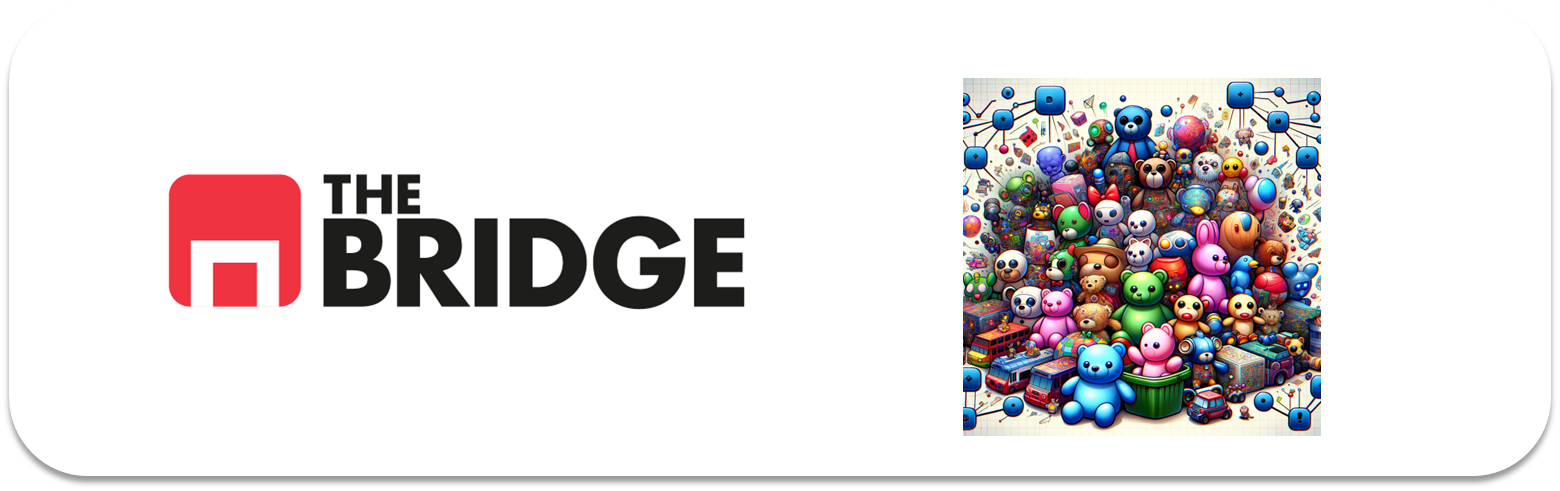

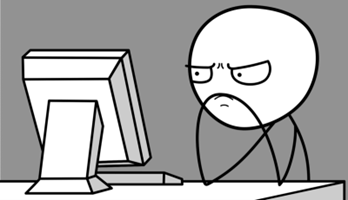

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

import toolbox_martin as tbm

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


In [2]:
df=pd.read_csv("./data/empowering_drinks.csv", sep="|")
df.head(20)

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276
5,1.716255,0.305159,0.492677,1.729520,0.083015
6,1.308617,0.890014,0.482637,1.745442,-0.003499
7,2.259772,-0.718336,0.954502,0.949319,0.061386
8,1.061565,-0.352802,1.125176,0.949319,0.935177
9,1.358028,-0.243142,1.295850,2.430109,0.299300


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


In [4]:
df.describe()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


Me saltan dudas con los valores negativos de los componentes... Le pregunto al jefe a ver que dice.

Mientras tanto hago una descripción de las variables

Azúcares: La cantidad de azúcar en la bebida
Vitaminas del grupo B: Cantidad de vitaminas B en la bebidad
Cafeína: Cantidad de cafeina en la bebida:
Ácido Cítrico: Cantidad de acido citrico en la bebida.
Taurina: Cantidad de Taurina en la bebida.



Datos limpios, todos numericos continuos y sin valores nulos.
RESPUESTA DEL JEFE: Son valores en escalas sobre una puntuación base de concentración estandar secreta por eso no te podemos dar el valor en terminos reales y positivos de la concentración... vamos, como la formula de la cocacola!

### MINIEDA

1. Analisis univariante: forma de los datos, presencia de outliers, presenta largas colas, datos agrupados o no...
2. Comparacion bivariante: Posible correlacion, forma de los clusters (a ojo), si hay tendencias o patrones...
3. Seleccion de features segun criterios evaluados anteriormente

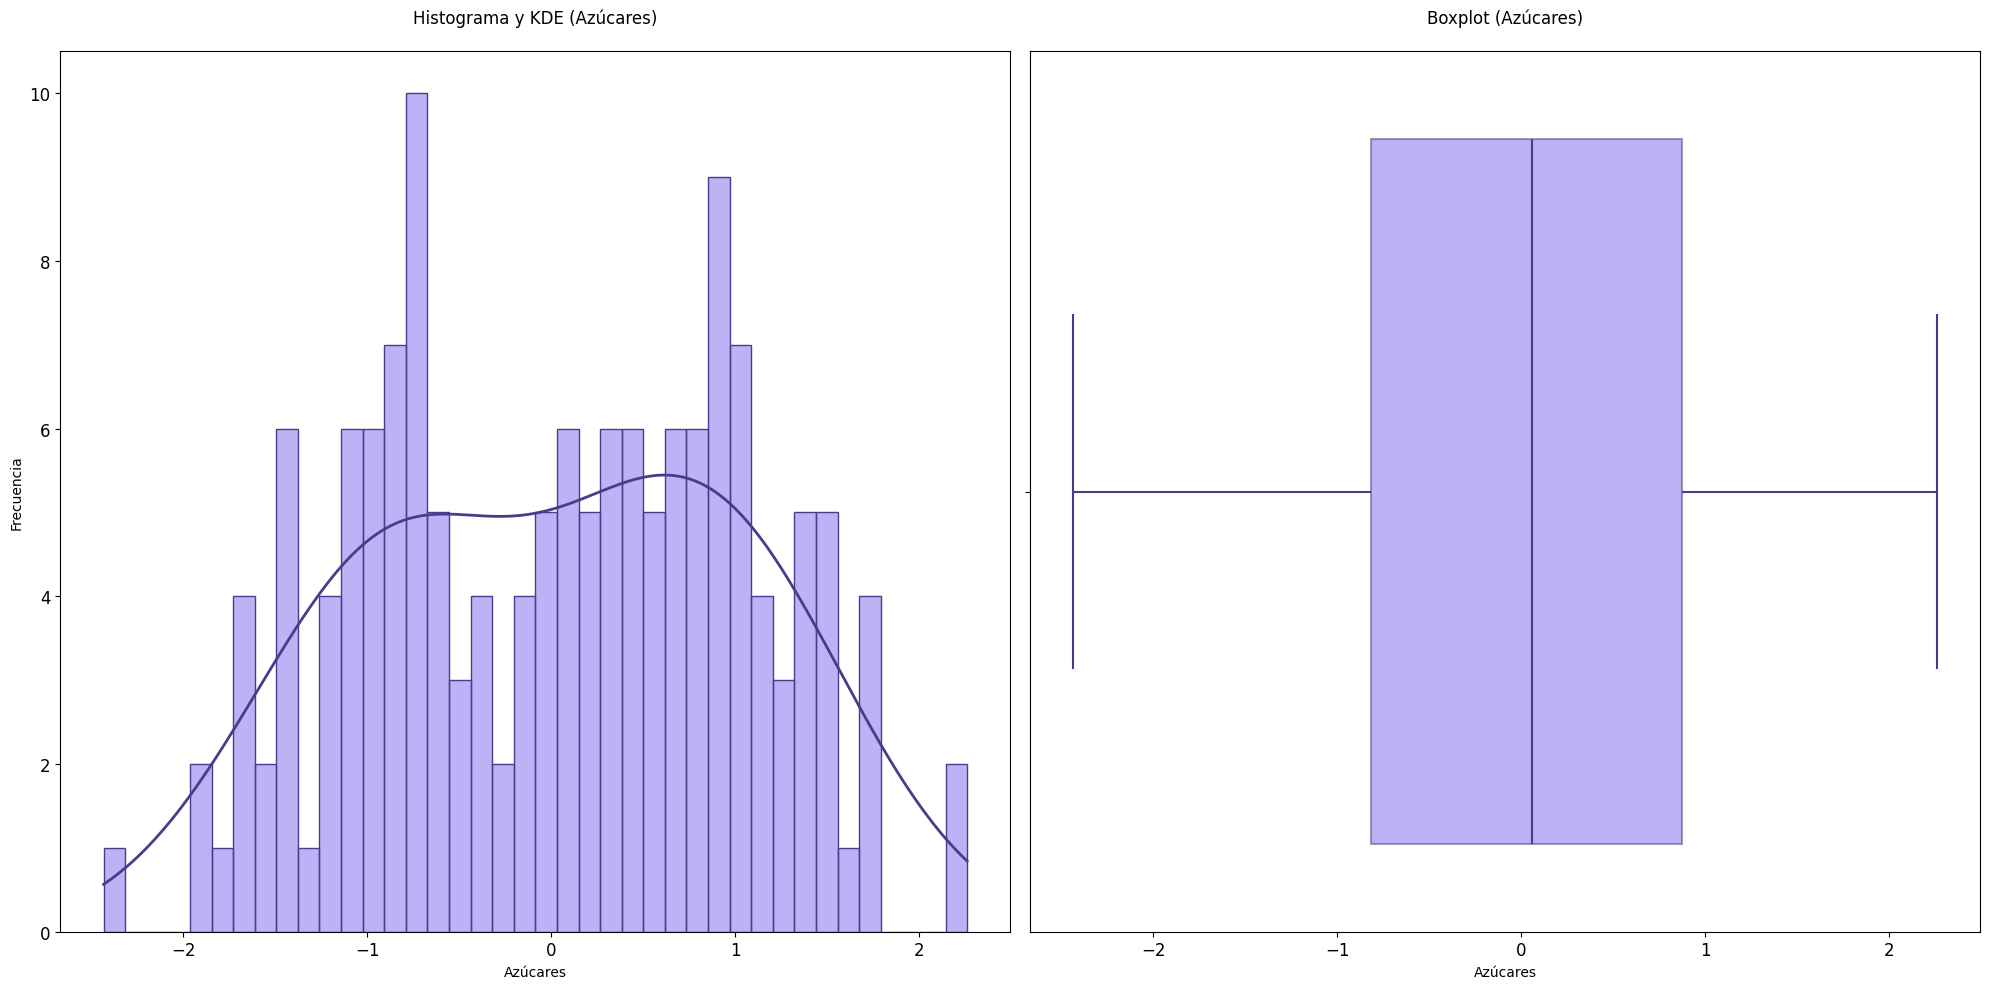

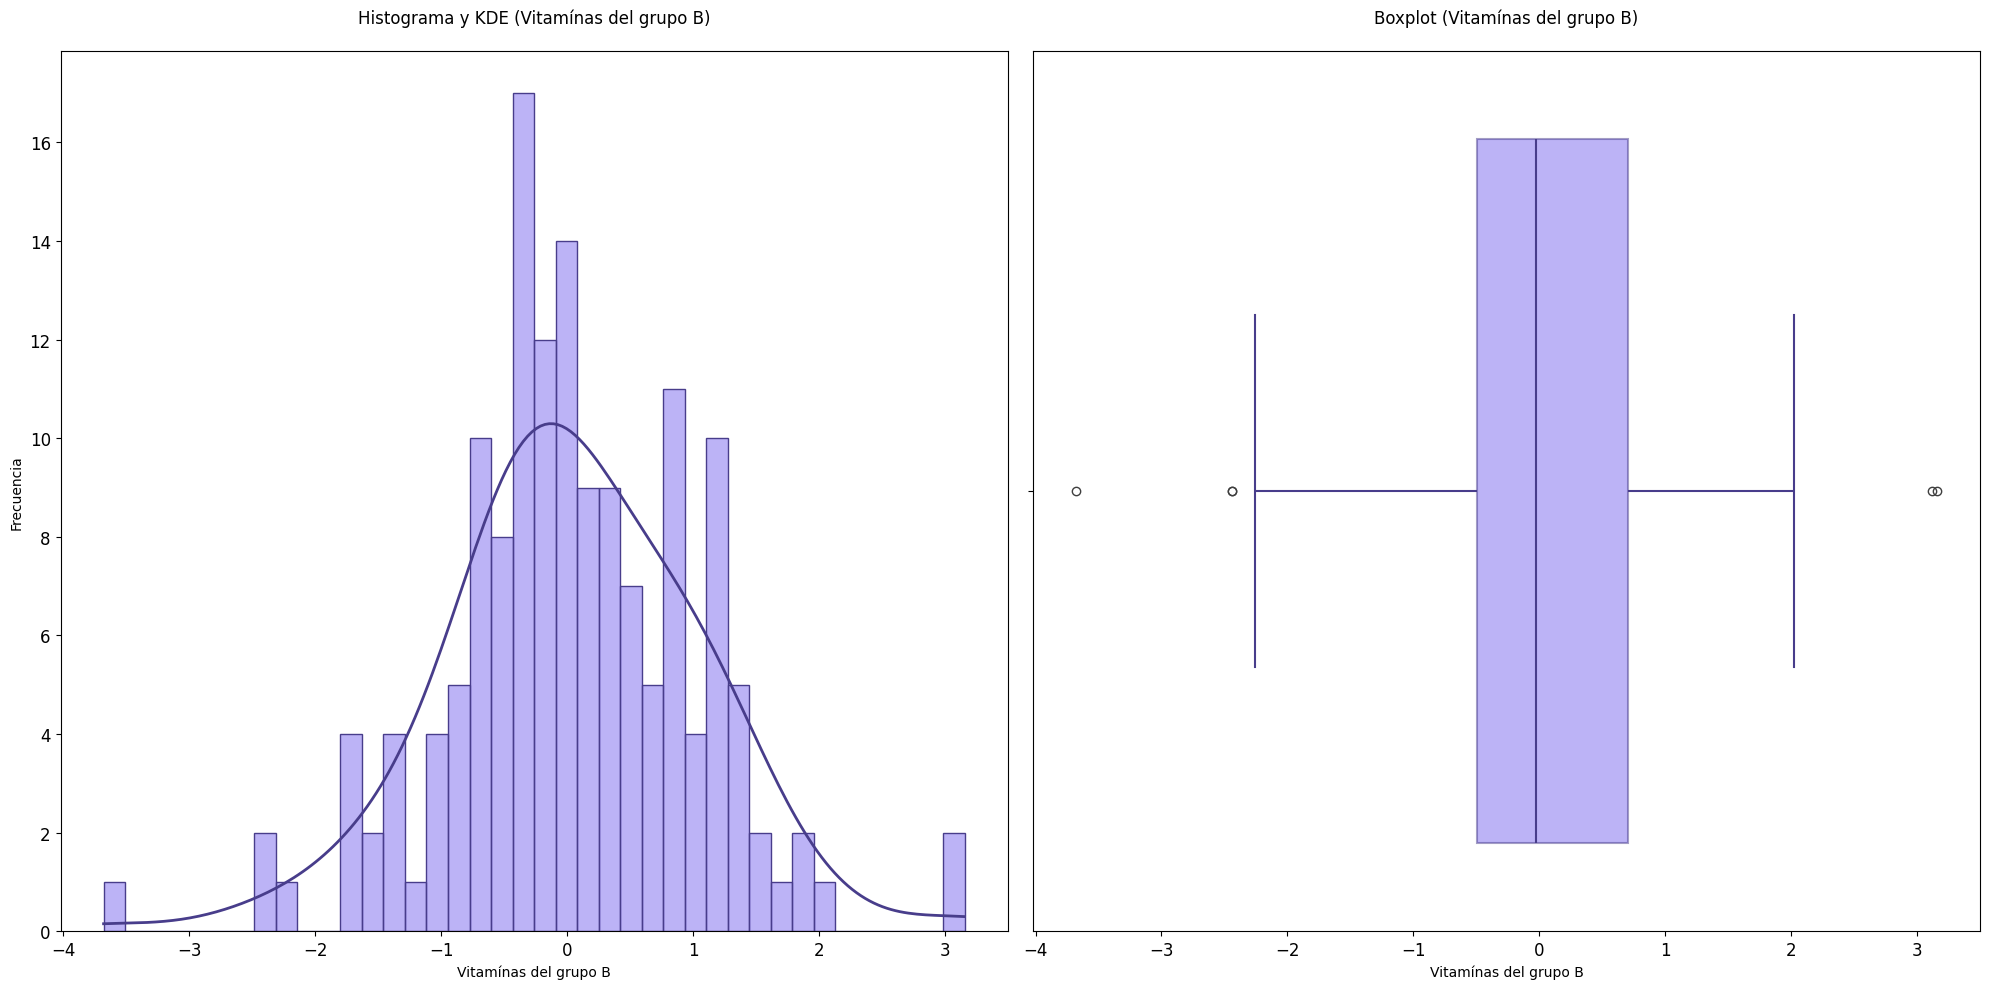

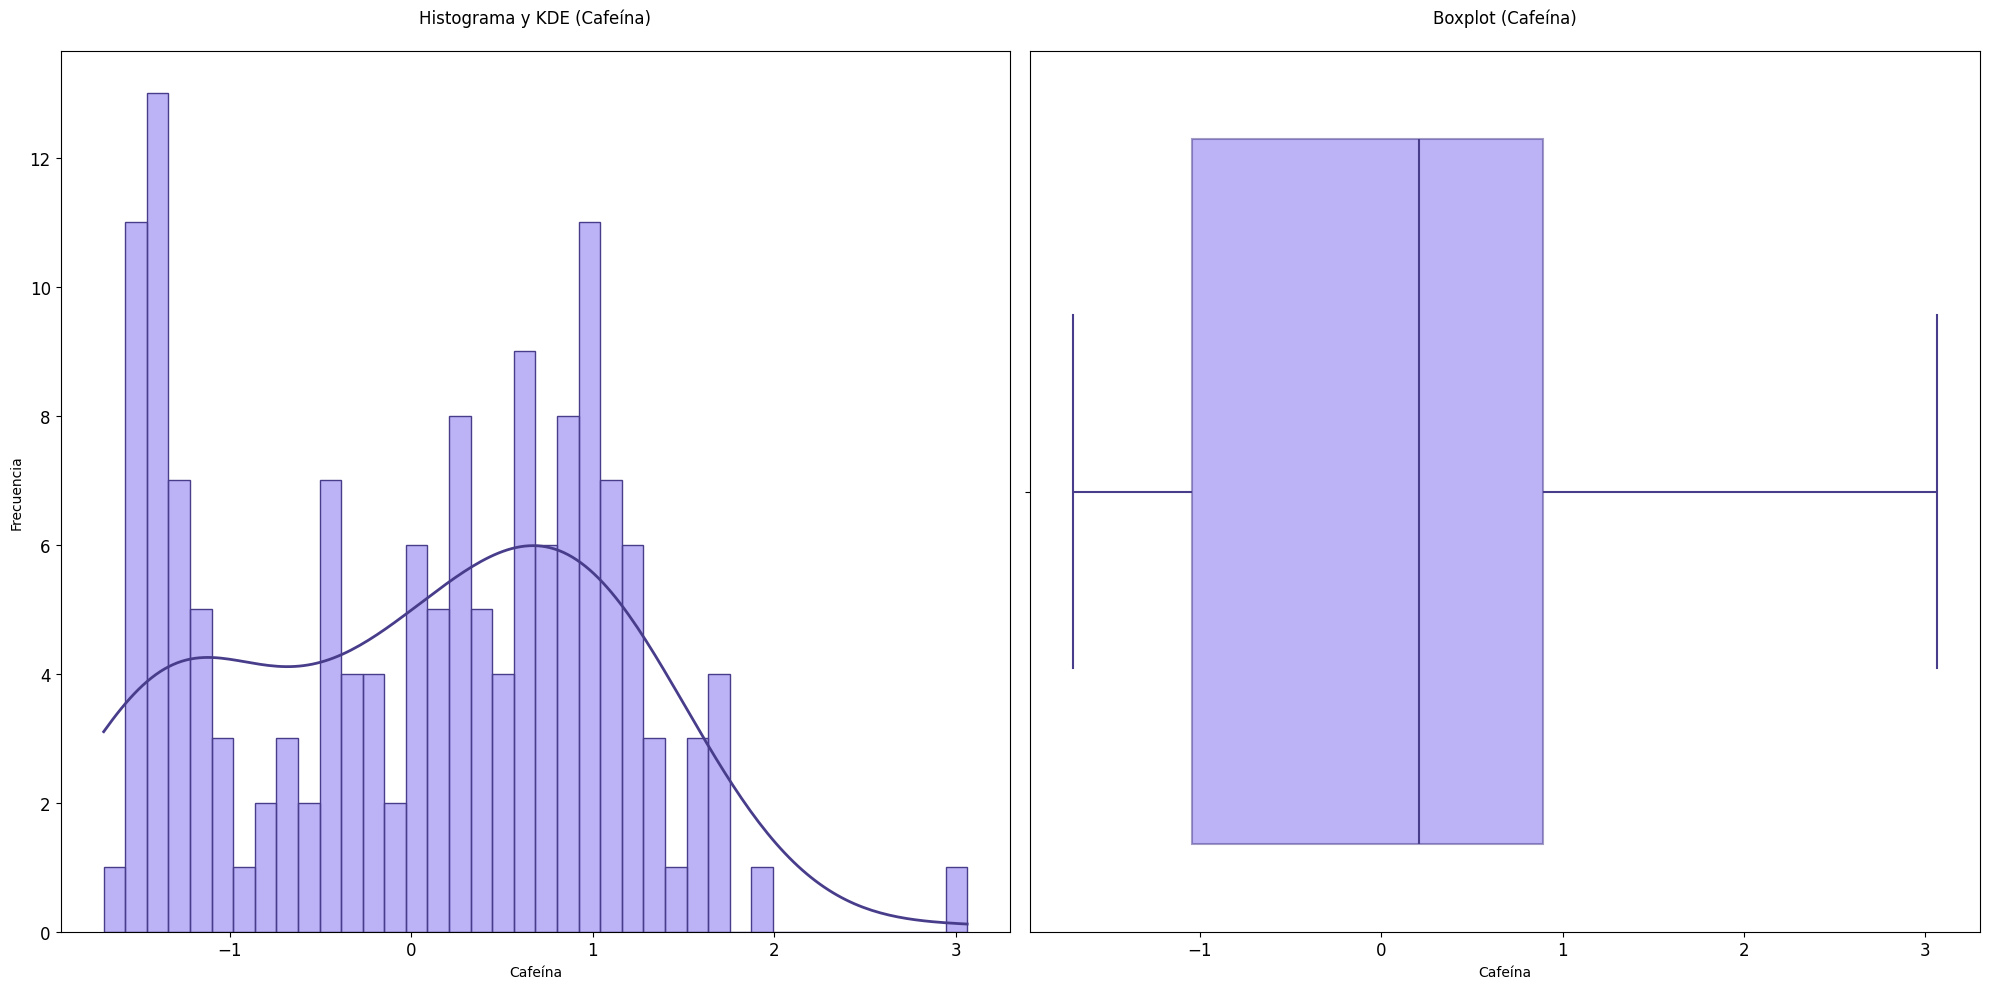

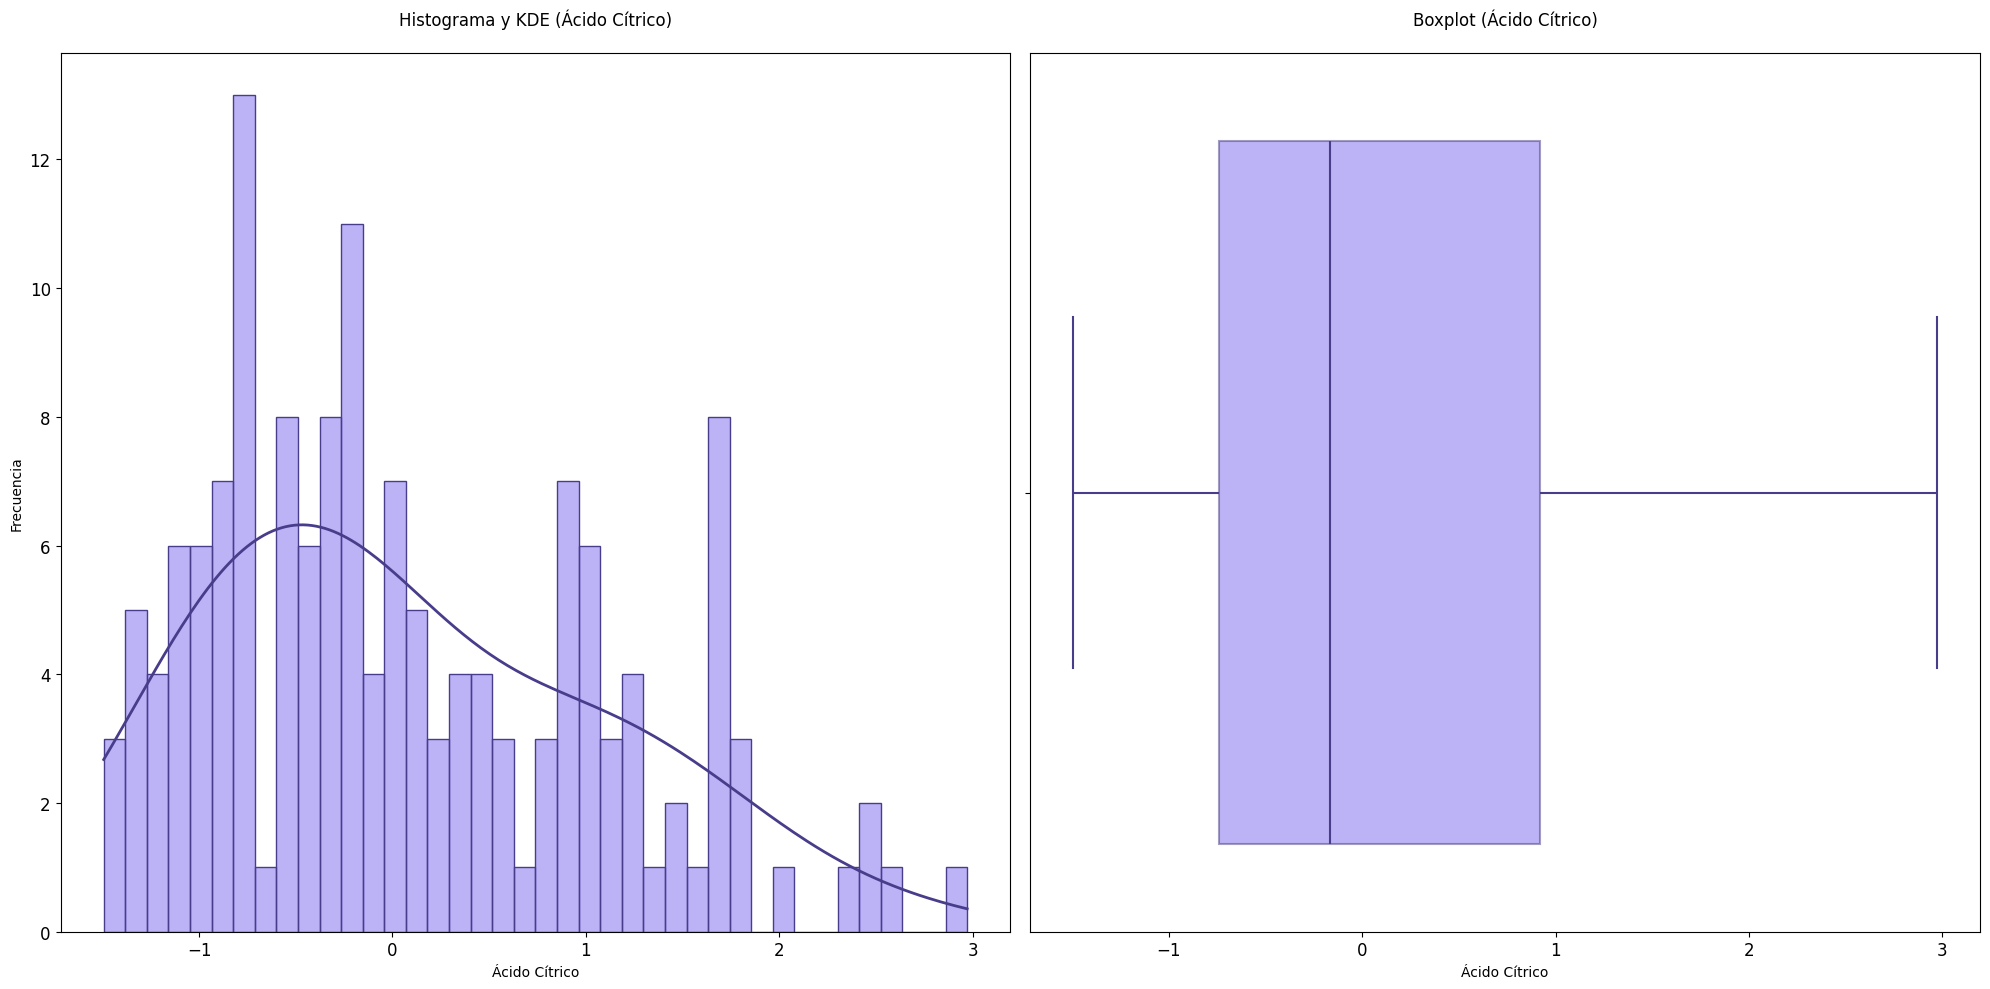

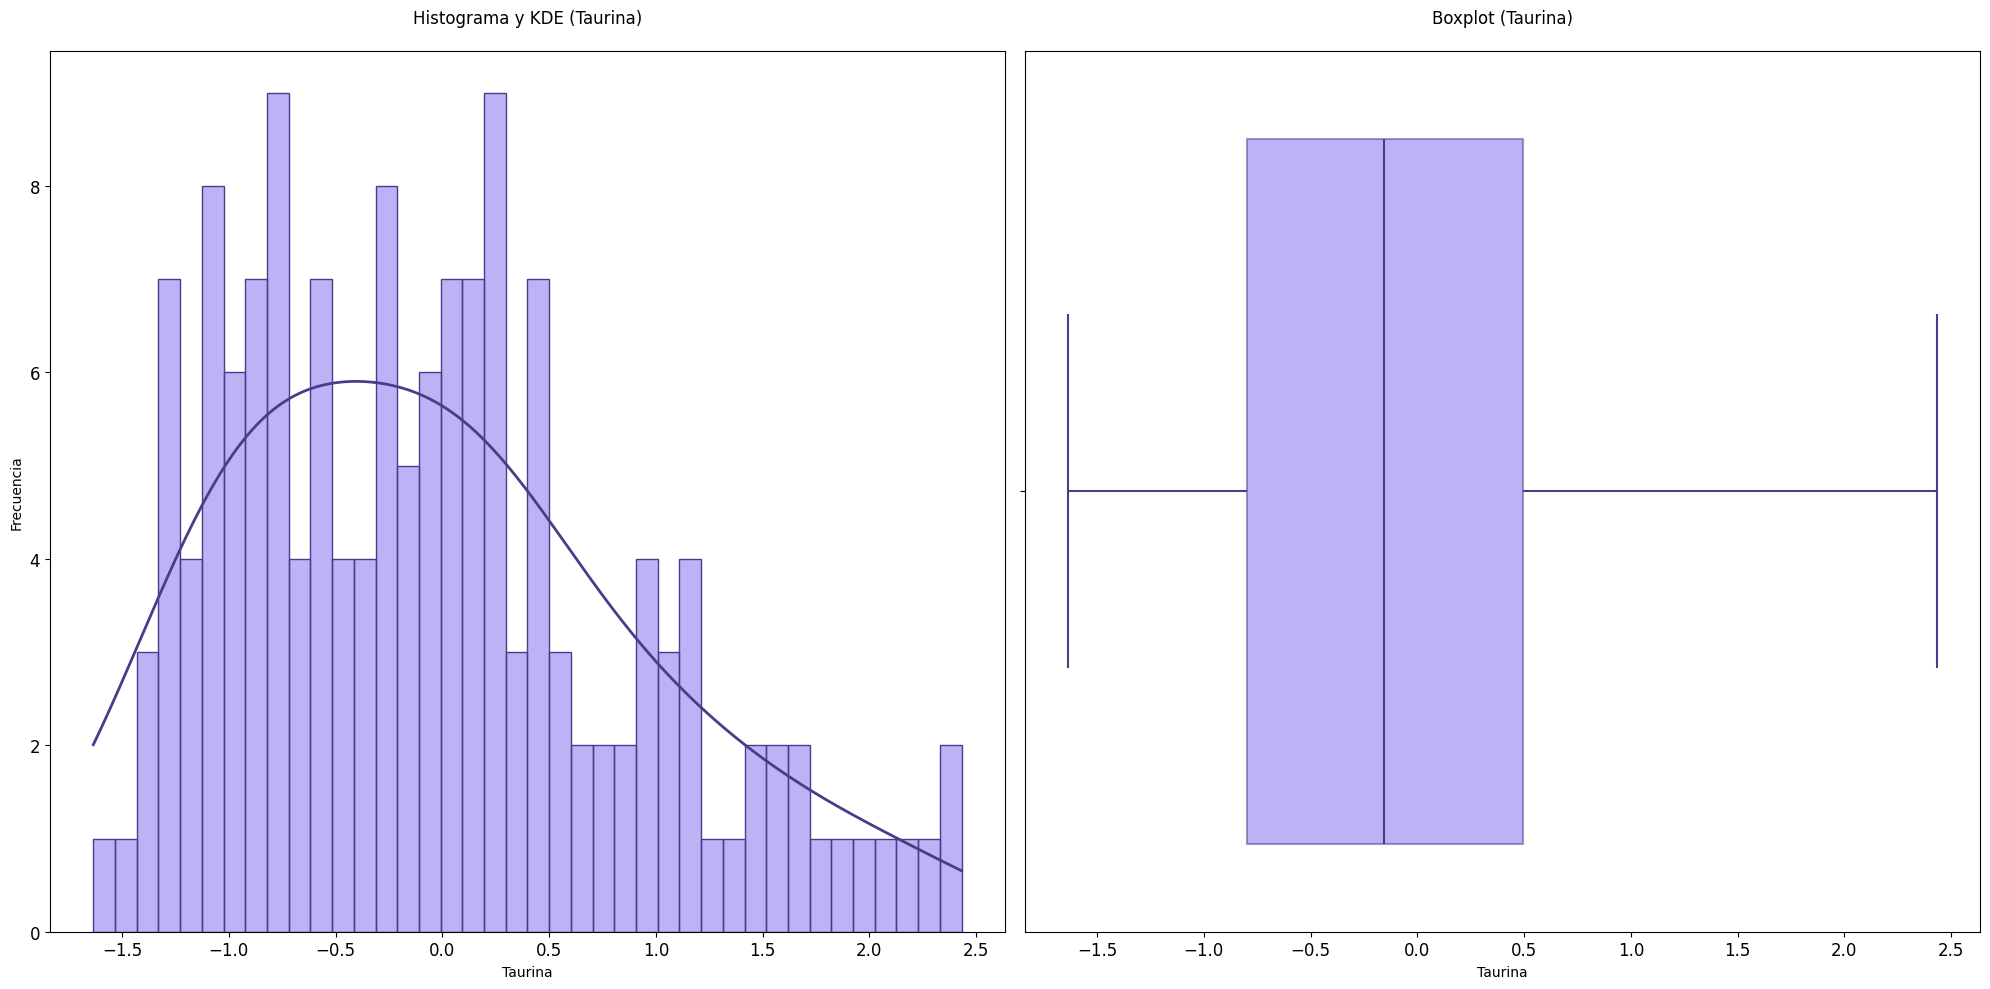

In [5]:
# vemos las graficas individualmente
for col in df.columns:
    tbm.histo_box(df,col)

Vemos que la cafeina presenta un hueco al final de su cola, puede ser interesante. El resto de valores presentan una forma bastante bonita y el rango de valores parece uniforme, lo escalaremos.

Vemos la presencia de unos pocos outliers en vitaminas del grupo B

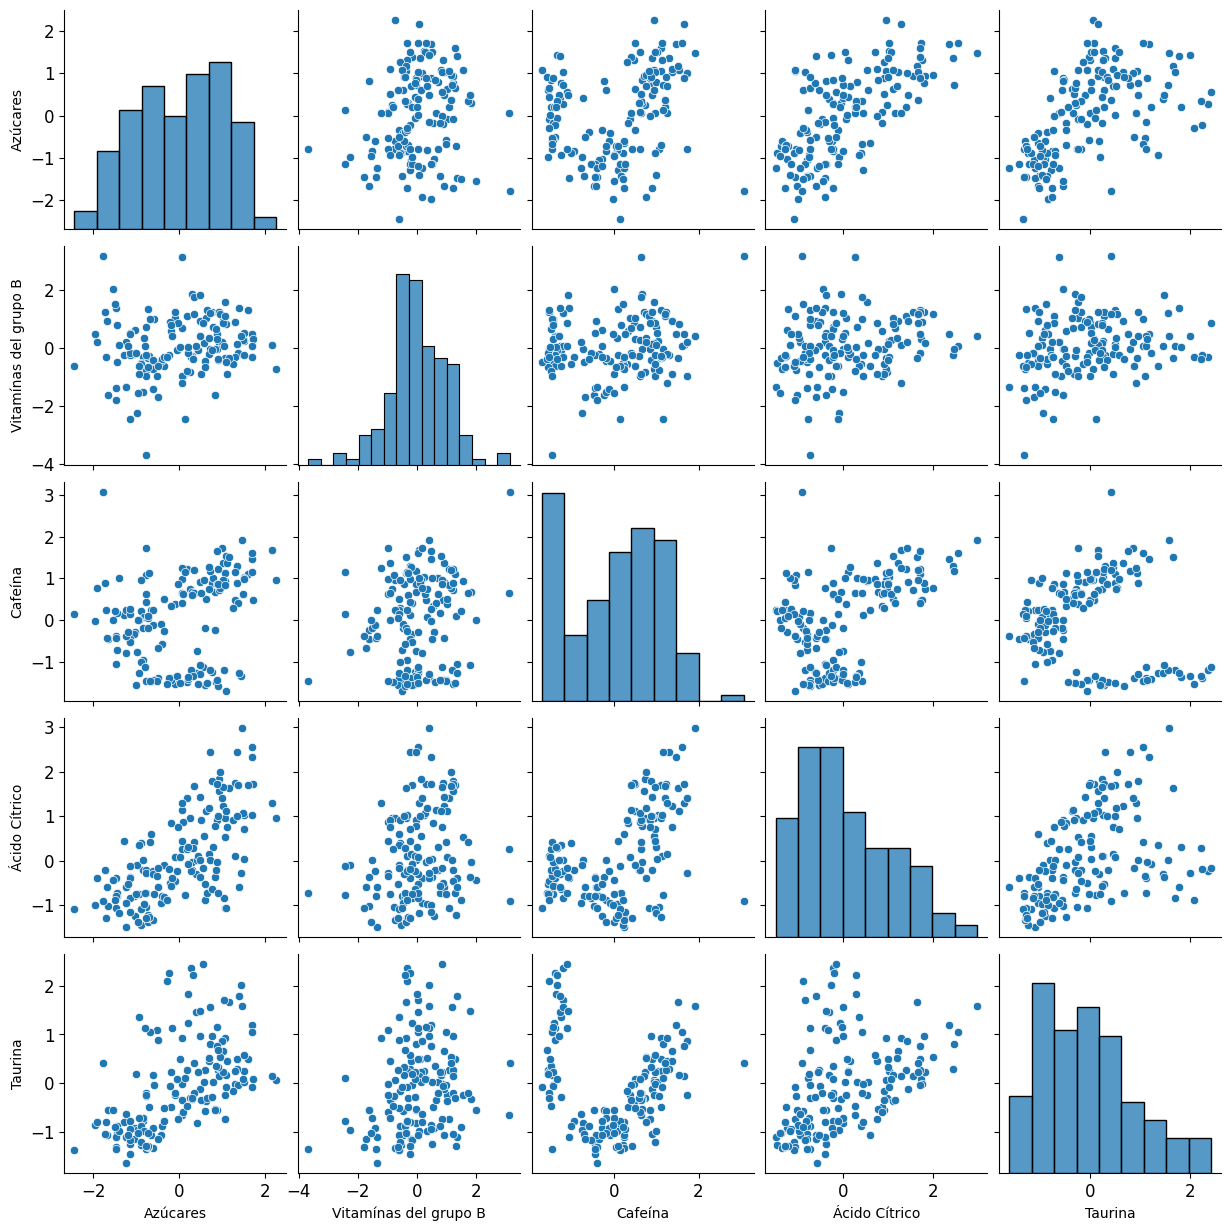

In [6]:
#Comparamos los datos con el pairplot
sns.pairplot(df)

Si analizo taurina con cafeina puedo separar por lo menos 2 grupos. Quiza 4 si los subdivido.
Si analizo acido citrico y cafeina, puedo tener 2/3 clusters.

Si analizo azucares con cafeina podria separar en 3 clusters. En el resto me cuesta separar.

In [7]:
# Analizo correlacion
corr = df.corr(numeric_only = True)
corr

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
Azúcares,1.000000,0.174354,0.258166,0.672969,0.553245
Vitamínas del grupo B,0.174354,1.000000,0.155276,0.208444,0.215869
Cafeína,0.258166,0.155276,1.000000,0.497329,-0.124157
Ácido Cítrico,0.672969,0.208444,0.497329,1.000000,0.408325
Taurina,0.553245,0.215869,-0.124157,0.408325,1.000000


<Axes: >

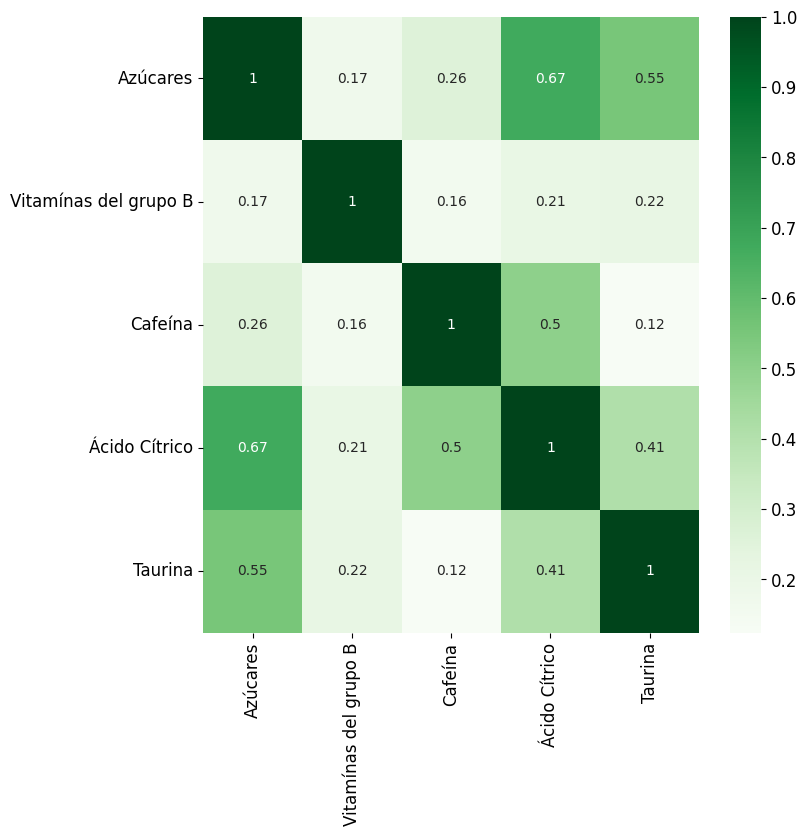

In [8]:
# heatmap correlacion
plt.figure(figsize = (8,8))
sns.heatmap(np.abs(corr), annot = True, cmap = "Greens")

Azucar con acido citrico tienen bastante relacion, y aazucar con taurina tambien.
Voy a probar 2 juegos de features distintos una con todas y otra sin azucar

In [9]:
feat_1=df.columns.to_list()
feat_1

['Azúcares', 'Vitamínas del grupo B', 'Cafeína', 'Ácido Cítrico', 'Taurina']

In [10]:
feat_2=df.columns.to_list()
feat_2.remove("Azúcares")
feat_2

['Vitamínas del grupo B', 'Cafeína', 'Ácido Cítrico', 'Taurina']

### MODELO KNN

In [11]:
# creo mis set de datos
X_train_1=df[feat_1]
X_train_2=df[feat_2]

La mejor puntuación para el conjunto X_train_1 es de 0.3988 para k=3


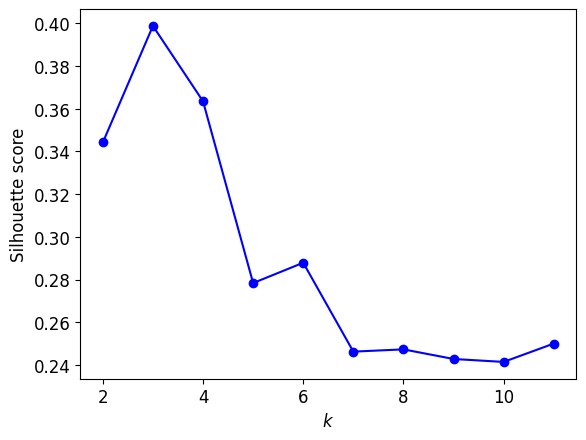

In [12]:
# Para todas las features
ks = []
sil_scores = []

# Pruebo entre k=2 y k=12, aunque nos dicen los químicos que es entre k=3 y k=5, por comprobar:
for k in range(2, 12): 
    clustering = KMeans(n_clusters=k, n_init=10, random_state=42)
    clustering.fit(X_train_1)

    sil_scores.append(silhouette_score(X_train_1, clustering.labels_))
    ks.append(k)

# Obtengo el valor de k que maximiza el silhouette score
val_max = max(sil_scores)
k_optimo = ks[sil_scores.index(val_max)]

# Graficamos score vs k
plt.plot(ks, sil_scores, "bo-")
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Silhouette score", fontsize=12)

# Imprimimos el valor de k que maximiza el silhouette score
print(f"La mejor puntuación para el conjunto X_train_1 es de {round(val_max,4)} para k={k_optimo}")


La mejor puntuación para el conjunto X_train_2 es de 0.3963 para k=3


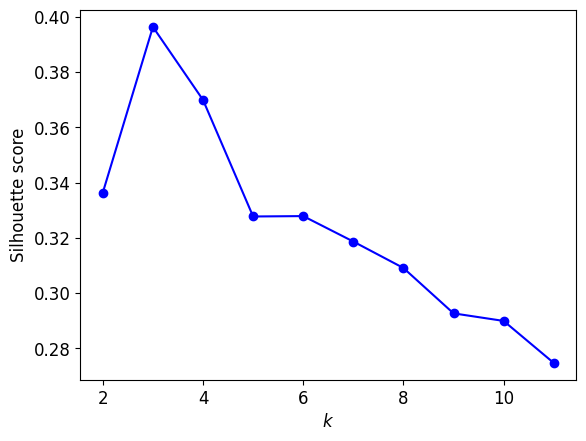

In [13]:
# Para todas las features menos azucar
ks = []
sil_scores = []

# Pruebo entre k=2 y k=12, aunque nos dicen los químicos que es entre k=3 y k=5, por comprobar:
for k in range(2, 12): 
    clustering = KMeans(n_clusters=k, n_init=10, random_state=42)
    clustering.fit(X_train_2)

    sil_scores.append(silhouette_score(X_train_2, clustering.labels_))
    ks.append(k)

# Obtengo el valor de k que maximiza el silhouette score
val_max = max(sil_scores)
k_optimo = ks[sil_scores.index(val_max)]

# Graficamos score vs k
plt.plot(ks, sil_scores, "bo-")
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Silhouette score", fontsize=12)

# Imprimimos el valor de k que maximiza el silhouette score
print(f"La mejor puntuación para el conjunto X_train_2 es de {round(val_max,4)} para k={k_optimo}")

En ambos casos el mejor silhouette score es para K=3.

In [14]:
#KMEANS todas las features
kmeans_model1 = KMeans(n_clusters = 3, random_state=42)
kmeans_model1.fit(X_train_1)

c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

In [15]:
#KMEANS todas las features menos azucar
kmeans_model2= KMeans(n_clusters = 3, random_state=42)
kmeans_model2.fit(X_train_2)

c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

In [16]:
df_cluster=df.copy()
df_cluster["Kmeans All"]=kmeans_model1.predict(X_train_1)
df_cluster["Kmeans NoSugar"]=kmeans_model2.predict(X_train_2)
df_cluster

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,Kmeans All,Kmeans NoSugar
0,1.518613,0.232053,1.034819,1.013009,0.251717,2,1
1,0.246290,-0.827996,0.733629,0.965242,-0.293321,2,1
2,0.196879,1.109334,1.215533,1.395148,0.269020,2,1
3,1.691550,0.487926,1.466525,2.334574,1.186068,2,1
4,0.295700,1.840403,0.663351,-0.037874,-0.319276,2,1
...,...,...,...,...,...,...,...
148,0.493343,0.414820,-1.284344,0.009893,0.969783,1,0
149,0.332758,-0.389355,-1.344582,0.280575,2.224236,1,0
150,0.209232,0.012732,-1.354622,0.296498,1.834923,1,0
151,1.395086,1.365208,-1.274305,-0.595160,1.791666,1,0


Hay clusters con distintos nombres, para cada conjunto, pero no sabemos si cambian en numero o de agrupacion

In [17]:
# ordenamos para que coincidan en la gráfica
df_cluster["Kmeans All"].replace({2: 1, 0: 2, 1: 0}, inplace=True)

In [18]:
df_cluster["Kmeans All"].value_counts()

Kmeans All
1    58
2    58
0    37
Name: count, dtype: int64

In [19]:
df_cluster["Kmeans NoSugar"].value_counts()

Kmeans NoSugar
1    60
2    56
0    37
Name: count, dtype: int64

Podria ser que algun valor se cambiase de grupo, vamos a verlo en un grafico. Compararemos ácido cítrico y Cafeina

Text(0.5, 1.0, 'Todas las features')

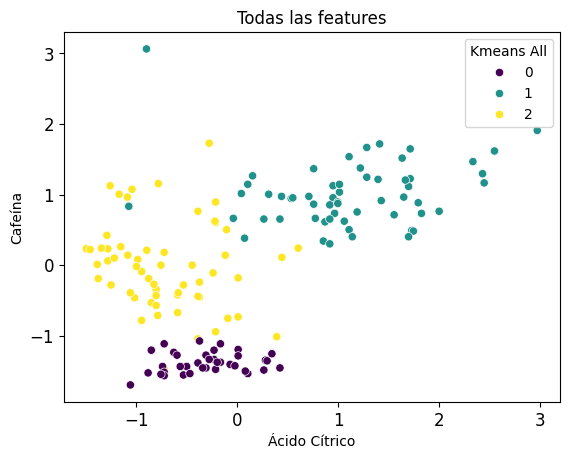

In [20]:
sns.scatterplot(x='Ácido Cítrico', 
                y='Cafeína', 
                data=df_cluster, 
                hue="Kmeans All", palette = "viridis").set_title("Todas las features")

Text(0.5, 1.0, 'Todas las features menos azúcares')

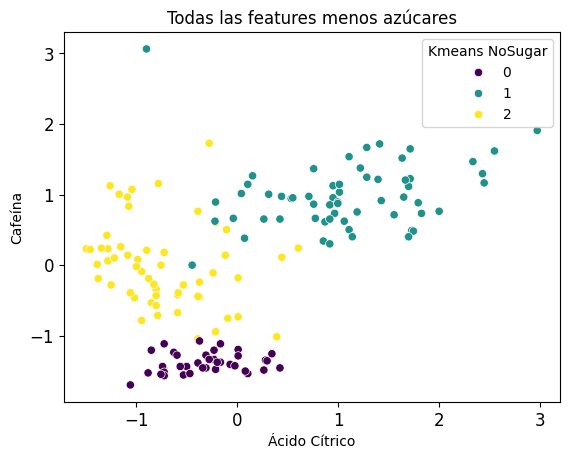

In [21]:
sns.scatterplot(x='Ácido Cítrico', 
                y='Cafeína', 
                data=df_cluster, 
                hue="Kmeans NoSugar", palette = "viridis").set_title("Todas las features menos azúcares")

Los valores del cluster 0, parece que los elige bien siempre.
Los del cluster 1 y 2, en general tambien, pero hay ligeros cambios en las zonas donde limitan.
Además, parece que la falta de azucares como features no afecta demasiado, asi que continuare usandolas todas.

### MODELO DBSCAN

Vamos a buscar un modelo, que consiga formar 3 cluster, para ello utilizaremos un valor de eps y un min_samples adecuado

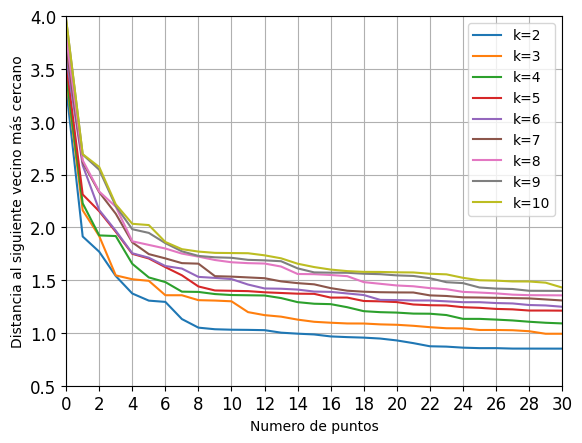

In [48]:
# Vamos a empezar calculando la distancia entre puntos, usaremos el set con todas las features:

num_samples = 2*len(X_train_1)

for k in range(2, min(11, num_samples)):
    k_neighbors = NearestNeighbors(n_neighbors=k)
    k_neighbors_fit=k_neighbors.fit(X_train_1)
    distances, indices = k_neighbors_fit.kneighbors(X_train_1)
    
    # Graficar la distancia k
    distances = distances[:, -1]  # Tomar la distancia al k-ésimo vecino
    distances = sorted(distances, reverse=True)
    plt.plot(distances, label=f'k={k}')

# Ajustar el número de marcas (ticks) en el eje x y más intervalos
num_ticks = 60
plt.xticks(np.arange(0, len(distances), len(distances)//num_ticks), rotation=0)

plt.xlabel('Numero de puntos')
plt.ylabel('Distancia al siguiente vecino más cercano')
plt.grid(True)
plt.legend(loc="upper right")

# Establecer límites para el zoom (ajusta estos valores según tu necesidad)
plt.xlim(0, 30)  # Límites en el eje x
plt.ylim(0.5, 4)  # Límites en el eje y

plt.show()

Para valores de k distintos podemos ver como el codo aumenta hacia el interior, subiendo desde k=2 a la altura de 1.3/1.5 hasta k=10 a una altura de 2/2.3

Epsilon: 0.50, Número de clusters: 0
Numero de elementos que tiene el clusters: 0
********************
Epsilon: 0.51, Número de clusters: 0
Numero de elementos que tiene el clusters: 0
********************
Epsilon: 0.52, Número de clusters: 0
Numero de elementos que tiene el clusters: 0
********************
Epsilon: 0.53, Número de clusters: 0
Numero de elementos que tiene el clusters: 0
********************
Epsilon: 0.54, Número de clusters: 0
Numero de elementos que tiene el clusters: 0
********************
Epsilon: 0.55, Número de clusters: 0
Numero de elementos que tiene el clusters: 0
********************
Epsilon: 0.56, Número de clusters: 0
Numero de elementos que tiene el clusters: 0
********************
Epsilon: 0.57, Número de clusters: 1
Numero de elementos que tiene el clusters: 1
********************
Epsilon: 0.58, Número de clusters: 1
Numero de elementos que tiene el clusters: 1
********************
Epsilon: 0.59, Número de clusters: 1
Numero de elementos que tiene el clu

Epsilon: 1.19, Número de clusters: 1
Numero de elementos que tiene el clusters: 109
********************
Epsilon: 1.20, Número de clusters: 1
Numero de elementos que tiene el clusters: 109
********************
Epsilon: 1.21, Número de clusters: 1
Numero de elementos que tiene el clusters: 110
********************
Epsilon: 1.22, Número de clusters: 1
Numero de elementos que tiene el clusters: 115
********************
Epsilon: 1.23, Número de clusters: 1
Numero de elementos que tiene el clusters: 118
********************
Epsilon: 1.24, Número de clusters: 1
Numero de elementos que tiene el clusters: 121
********************
Epsilon: 1.25, Número de clusters: 1
Numero de elementos que tiene el clusters: 123
********************
Epsilon: 1.26, Número de clusters: 1
Numero de elementos que tiene el clusters: 123
********************
Epsilon: 1.27, Número de clusters: 1
Numero de elementos que tiene el clusters: 125
********************
Epsilon: 1.28, Número de clusters: 1
Numero de elemento

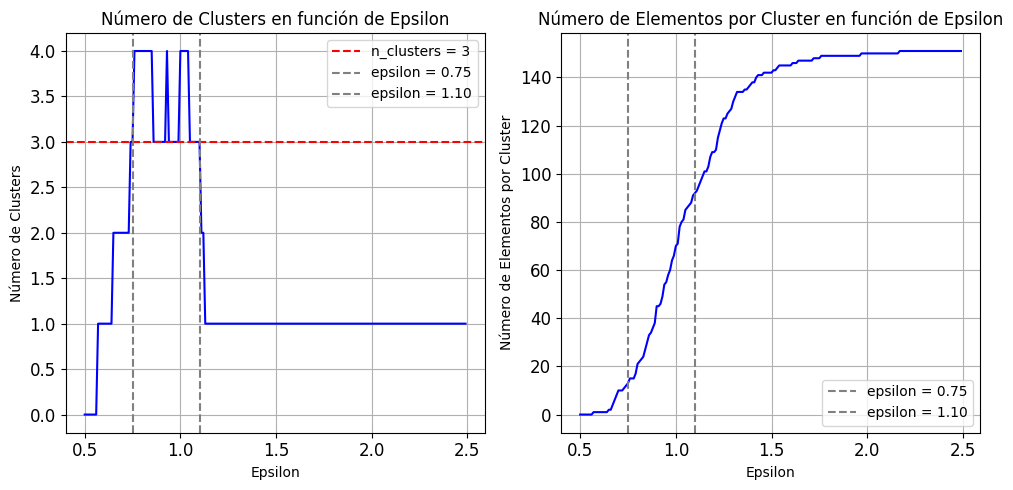

In [23]:
# Iteramos sobre los valores de epsilon
epsilons = np.arange(0.5, 2.5, 0.01)

# Listas para almacenar la información
num_clusters_list = []
num_elements_list = []

for epsilon in epsilons:
    # Crea una instancia de DBSCAN con el valor actual de epsilon
    dbscan = DBSCAN(eps=epsilon, min_samples=6) #numero de feat utilizadas +1

    # Aplica DBSCAN a tus datos
    labels = dbscan.fit_predict(X_train_1)

    # Contamos el número de clusters
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in labels else 0)

    # Almacenamos la información en las listas
    num_clusters_list.append(n_clusters)
    num_elements_list.append(len(dbscan.core_sample_indices_))

    print(f"Epsilon: {epsilon:.2f}, Número de clusters: {n_clusters}")
    # Cuantos core_sample_indices_
    print(f"Numero de elementos que tiene el clusters: {len(dbscan.core_sample_indices_)}")
    print("*"*20)

# Graficamos el número de clusters y el número de elementos por cluster en función de epsilon
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epsilons, num_clusters_list, 'b-')
plt.title('Número de Clusters en función de Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Número de Clusters')

# Agregamos la recta discontinua en y=3
plt.axhline(y=3, color='r', linestyle='--', label='n_clusters = 3')
plt.axvline(x=0.75, color='grey', linestyle='--', label='epsilon = 0.75')
plt.axvline(x=1.10, color='grey', linestyle='--', label='epsilon = 1.10')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epsilons, num_elements_list, 'b-')
plt.title('Número de Elementos por Cluster en función de Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Número de Elementos por Cluster')

# Agregamos la recta discontinua en x=1
plt.axvline(x=0.75, color='grey', linestyle='--', label='epsilon = 0.75')
plt.axvline(x=1.10, color='grey', linestyle='--', label='epsilon = 1.10')
plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()

Para valores de eps=0.75 tendre 3 clusters pero con pocos elementos, quedando muchos valores como anómalos.

Sin embargo si uso un eps=1.10, tendre 3 clusters pero con muchos elementos. Usaremos este valor

In [24]:
# Modelo de DBSCAN con el eps maximo para 3 clusters
dbscan1 = DBSCAN(eps=1.10,
                min_samples=6)
dbscan1.fit(X_train_1)

DBSCAN(eps=1.1, min_samples=6)

In [25]:
# El algoritmo
print(dbscan1)

# Todos los datos etiquetados
print(len(dbscan1.labels_))

# Etiquetas de todos los datos
print(dbscan1.labels_)

# Cuantos clusters ha montado
print(np.unique(dbscan1.labels_))

DBSCAN(eps=1.1, min_samples=6)
153
[ 0  0  0 -1  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1  0  0  0  0  0 -1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1
  0  0  0  0  0  0  0  0 -1  1 -1  1  1  0 -1  2  1  1 -1  1  0 -1  1  1
  1  1  0  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2 -1  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2]
[-1  0  1  2]


In [26]:
# Cuantos core_sample_indices_
print(len(dbscan1.core_sample_indices_))

# Los indices de los 5 primeros core_sample
print(dbscan1.core_sample_indices_[:5])

# La posicion (coordenadas) de los 5 primeros core_sample
print(dbscan1.components_[:5])

92
[0 1 2 5 6]
[[ 1.51861254  0.23205254  1.03481896  1.01300893  0.25171685]
 [ 0.24628963 -0.82799632  0.73362894  0.96524152 -0.29332133]
 [ 0.19687903  1.10933436  1.21553297  1.39514818  0.26901965]
 [ 1.71625494  0.30515936  0.49267693  1.72952002  0.08301456]
 [ 1.3086175   0.89001391  0.48263726  1.74544249 -0.00349944]]


No entiendo por que tengo 5 core_sample_indices_

In [27]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    """
    Visualiza los resultados de un algoritmo DBSCAN.

    Parámetros:
    - dbscan (objeto): El modelo DBSCAN ya ajustado.
    - X (array-like): Los datos de entrada para los cuales se realizó el clustering.
    - size (int): Tamaño de los marcadores en la gráfica.
    - show_xlabels (bool, opcional): Indica si mostrar las etiquetas del eje x. Por defecto, True.
    - show_ylabels (bool, opcional): Indica si mostrar las etiquetas del eje y. Por defecto, True.

    Nota:
    - La función espera que X sea un array-like (por ejemplo, un array de NumPy) y no un DataFrame de Pandas.

    Ejemplo de uso:
    ```python
    plot_dbscan(dbscan_model, data_array, size=100, show_xlabels=True, show_ylabels=True)
    ```

    """
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='^', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

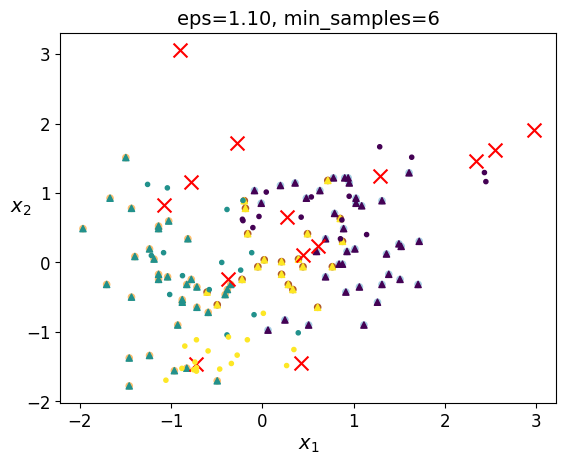

In [28]:
#probamos para Acído citrico y cafeina
plot_dbscan(dbscan1,X_train_1[["Ácido Cítrico","Cafeína"]].values,size=20)

In [29]:
df_cluster["DBSCAN"]=dbscan1.labels_
df_cluster

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,Kmeans All,Kmeans NoSugar,DBSCAN
0,1.518613,0.232053,1.034819,1.013009,0.251717,1,1,0
1,0.246290,-0.827996,0.733629,0.965242,-0.293321,1,1,0
2,0.196879,1.109334,1.215533,1.395148,0.269020,1,1,0
3,1.691550,0.487926,1.466525,2.334574,1.186068,1,1,-1
4,0.295700,1.840403,0.663351,-0.037874,-0.319276,1,1,0
...,...,...,...,...,...,...,...,...
148,0.493343,0.414820,-1.284344,0.009893,0.969783,0,0,2
149,0.332758,-0.389355,-1.344582,0.280575,2.224236,0,0,2
150,0.209232,0.012732,-1.354622,0.296498,1.834923,0,0,2
151,1.395086,1.365208,-1.274305,-0.595160,1.791666,0,0,2


El cluster que forma es muy distinto al de KNN y ademas deja valores anómalos por fuera

### MODELO JERARQUICO

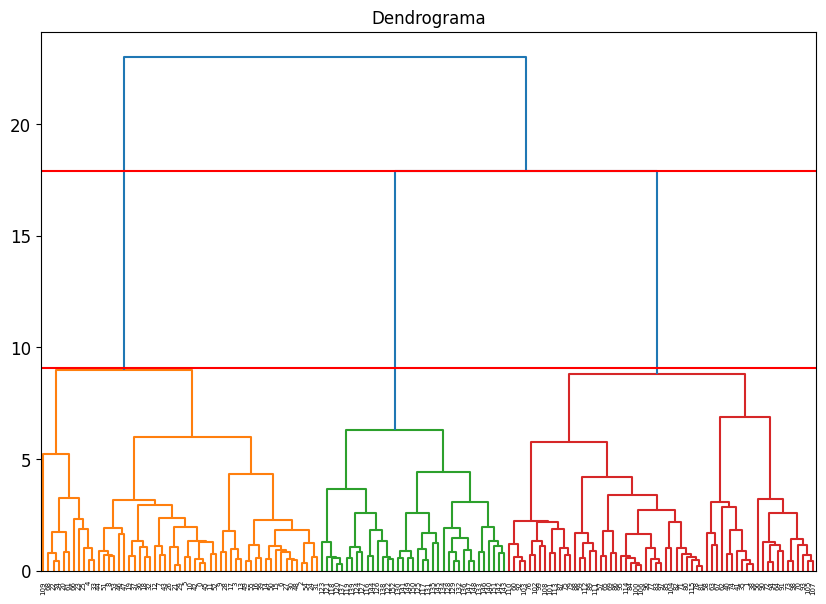

In [30]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Dendrograma")

selected_data = df
clusters = shc.linkage(selected_data, 
            method='ward',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.axhline(y = 17.9, color = 'r', linestyle = '-')
plt.axhline(y = 9.1, color = 'r', linestyle = '-')
plt.show()


Con el modelo jerarquico, al graficarno ya nos recomienda 3 clusters. Con una distancia entre clusters "ward" superior a 9 y por debajo de 18.

Otra opcion seria una distancia de 8 por ejemplo y tener 5 cluster.

In [31]:
from sklearn.cluster import AgglomerativeClustering

In [32]:
# modelo 1 Jerarquico, k=3
model_jer1 = AgglomerativeClustering(n_clusters=3,
                                           metric='euclidean',
                                           linkage='ward')
model_jer1.fit(selected_data)
model_jer1.labels_

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int64)

In [33]:
# modelo 2 Jerarquico, k=5
model_jer2 = AgglomerativeClustering(n_clusters=5,
                                           metric='euclidean',
                                           linkage='ward')
model_jer2.fit(selected_data)
model_jer2.labels_

array([1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 4, 0, 4, 4, 3, 0, 0, 0, 4,
       3, 0, 3, 4, 0, 4, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 0, 0, 4, 0, 0, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 3,
       4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int64)

In [34]:
df_cluster["Jer_k3"]=model_jer1.labels_
df_cluster["Jer_k5"]=model_jer2.labels_
df_cluster

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,Kmeans All,Kmeans NoSugar,DBSCAN,Jer_k3,Jer_k5
0,1.518613,0.232053,1.034819,1.013009,0.251717,1,1,0,0,1
1,0.246290,-0.827996,0.733629,0.965242,-0.293321,1,1,0,1,0
2,0.196879,1.109334,1.215533,1.395148,0.269020,1,1,0,0,1
3,1.691550,0.487926,1.466525,2.334574,1.186068,1,1,-1,0,1
4,0.295700,1.840403,0.663351,-0.037874,-0.319276,1,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...
148,0.493343,0.414820,-1.284344,0.009893,0.969783,0,0,2,2,2
149,0.332758,-0.389355,-1.344582,0.280575,2.224236,0,0,2,2,2
150,0.209232,0.012732,-1.354622,0.296498,1.834923,0,0,2,2,2
151,1.395086,1.365208,-1.274305,-0.595160,1.791666,0,0,2,2,2


Text(0.5, 1.0, 'Todas las features')

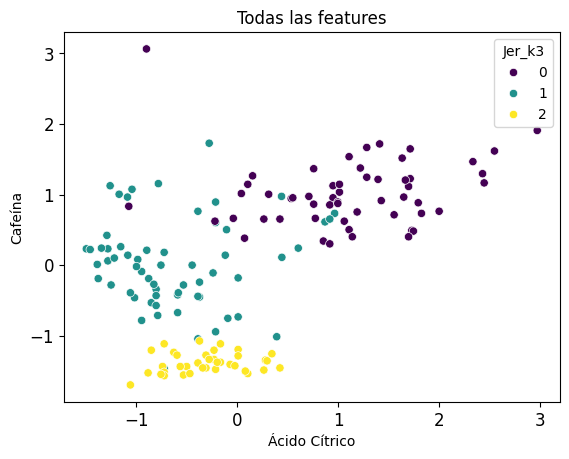

In [35]:
sns.scatterplot(x='Ácido Cítrico', 
                y='Cafeína', 
                data=df_cluster, 
                hue="Jer_k3", palette = "viridis").set_title("Todas las features")

Text(0.5, 1.0, 'Todas las features')

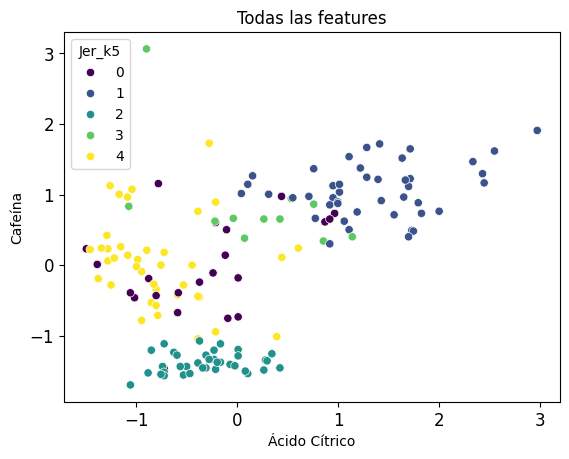

In [36]:
sns.scatterplot(x='Ácido Cítrico', 
                y='Cafeína', 
                data=df_cluster, 
                hue="Jer_k5", palette = "viridis").set_title("Todas las features")

El cluster para k=3 se parece mucho al modelo obtenido por knn, el de k=5 tiene pocos valores del grupo 0 y grupo 3

Vamos a intentar encontrar un patrón en esos datos para ver que tienen en comun esas agrupaciones:


In [37]:
# lo vemos con el modelo jerarquico k=3:
grupo_0=df_cluster.loc[df_cluster["Jer_k3"]==0][feat_1]
grupo_1=df_cluster.loc[df_cluster["Jer_k3"]==1][feat_1]
grupo_2=df_cluster.loc[df_cluster["Jer_k3"]==2][feat_1]

In [38]:
grupo_0.describe()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,55.000000,55.000000,55.000000,55.000000,55.000000
mean,0.891996,0.520492,1.020946,1.102175,0.230639
std,0.703994,0.846818,0.476398,0.807384,0.537457
min,-1.779545,-1.193530,0.301923,-1.072834,-0.738868
25%,0.610693,-0.023821,0.688450,0.734366,-0.133270
50%,0.950391,0.487926,0.954502,1.108544,0.234414
75%,1.358028,1.036228,1.235612,1.681753,0.504770
max,2.259772,3.156325,3.062832,2.971473,1.661895


In [39]:
grupo_1.describe()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,61.000000,61.000000,61.000000,61.000000,61.000000
mean,-0.873346,-0.491226,0.021142,-0.609412,-0.884453
std,0.668137,1.033092,0.630541,0.613872,0.361120
min,-2.434235,-3.679162,-1.465058,-1.493188,-1.634288
25%,-1.285439,-0.974210,-0.420933,-1.056912,-1.128181
50%,-0.877801,-0.462462,0.000733,-0.779861,-0.916222
75%,-0.606043,0.049285,0.261765,-0.238497,-0.717240
max,0.826864,2.023170,1.727556,0.965242,0.104643


In [40]:
grupo_2.describe()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,37.000000,37.000000,37.000000,37.000000,37.000000
mean,0.193422,0.190284,-1.382700,-0.302761,0.933003
std,0.643357,0.692710,0.144322,0.379891,0.861753
min,-0.988975,-0.974210,-1.695971,-1.056912,-0.457698
25%,-0.223111,-0.316249,-1.485138,-0.595160,0.191157
50%,0.209232,0.039106,-1.404820,-0.308556,1.056297
75%,0.641574,0.780354,-1.274305,-0.021952,1.558078
max,1.432144,1.803849,-1.073511,0.423878,2.431870


Veo que los valores para cada grupo cambian bastante, vamos a graficarlos.

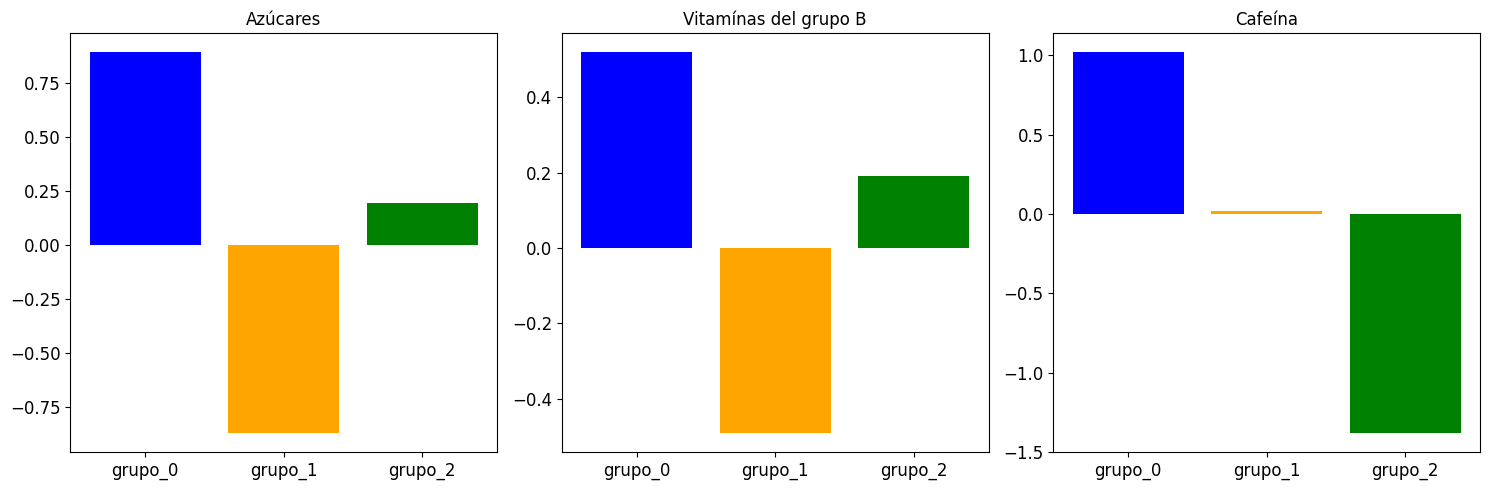

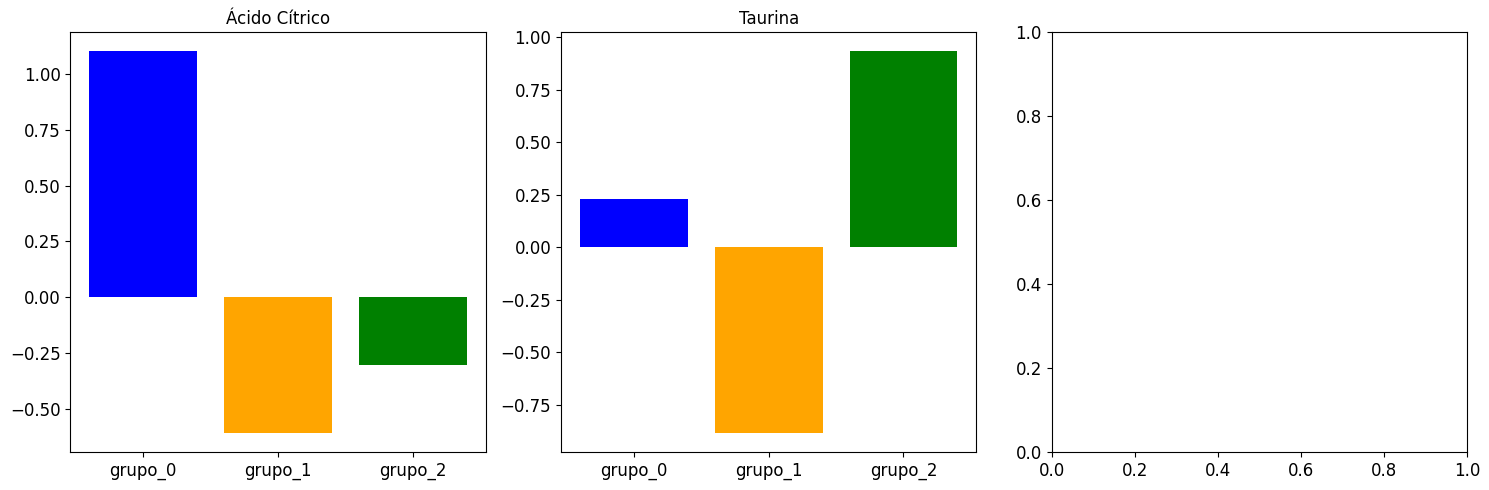

In [41]:
grupos = ['grupo_0', 'grupo_1', 'grupo_2']
columnas = ['Azúcares', 'Vitamínas del grupo B', 'Cafeína', 'Ácido Cítrico', 'Taurina']

# Iterar sobre las columnas de 3 en 3
for i in range(0, len(columnas), 3):
    # Seleccionar las columnas actuales
    columnas_actuales = columnas[i:i+3]
    
    # Crear subgráficos
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Iterar sobre las columnas actuales
    for j, col in enumerate(columnas_actuales):
        # Obtener los valores medios para cada grupo
        valores_medios = [grupo[col].mean() for grupo in [grupo_0, grupo_1, grupo_2]]
        
        # Graficar barras
        axs[j].bar(grupos, valores_medios, color=['blue', 'orange', 'green'])
        axs[j].set_title(col)
    
    # Ajustar el diseño y mostrar el gráfico
    plt.tight_layout()
    plt.show()

Como resumen, el grupo0 tiene bastante de todo, menos de taurina que tiene menos.
El grupo1 tiene valores negativos altos en todas, menos en cafeina que es practicamente 0.
El grupo2 tiene poco de azucar, vitamina b, mucha taurina y valores negativos de acido citrico y cafeina

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [42]:
data = pd.read_csv("./data/new_experiments.csv", sep="|")
data

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043


In [43]:
# vemos la prediccion de esos datos con KNN
predicted1=kmeans_model1.predict(data[feat_1])
predicted1

array([2, 2, 0, 0, 1, 1])

las distribuciones van 2 para cada lado con este modelo

In [49]:
# vemos la prediccion de esos datos con Agglomerative clustering
predicted_labels1 = model_jer1.fit_predict(data[feat_1])
predicted_labels1

array([1, 1, 0, 0, 0, 2], dtype=int64)

las distribuciones varian 2/3/1 ... no sabria con cual quedarme

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.

In [45]:
df_cluster

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,Kmeans All,Kmeans NoSugar,DBSCAN,Jer_k3,Jer_k5
0,1.518613,0.232053,1.034819,1.013009,0.251717,1,1,0,0,1
1,0.246290,-0.827996,0.733629,0.965242,-0.293321,1,1,0,1,0
2,0.196879,1.109334,1.215533,1.395148,0.269020,1,1,0,0,1
3,1.691550,0.487926,1.466525,2.334574,1.186068,1,1,-1,0,1
4,0.295700,1.840403,0.663351,-0.037874,-0.319276,1,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...
148,0.493343,0.414820,-1.284344,0.009893,0.969783,0,0,2,2,2
149,0.332758,-0.389355,-1.344582,0.280575,2.224236,0,0,2,2,2
150,0.209232,0.012732,-1.354622,0.296498,1.834923,0,0,2,2,2
151,1.395086,1.365208,-1.274305,-0.595160,1.791666,0,0,2,2,2


In [50]:
df_results=pd.read_csv("./data/power_results.csv" ,sep="|")
df_results

,class
0,1
1,1
2,1
3,1
4,1
...,...
154,1
155,2
156,2
157,3
